Prognozowana suma zakażeń w grudniu: 21269

W analizie ilościowej użyto biblioteki NeuralProphet do prognozowania ilości nowych przypadków zachorowań (new_cases). NeuralProphet to zaawansowany model prognozowania czasowego, wykorzystujący głęboką sieć neuronową do modelowania złożonych wzorców w danych szeregów czasowych. Oparta na koncepcji modelu Prophet, ta biblioteka automatycznie rozpoznaje i uwzględnia różne formy sezonowości, umożliwiając dostosowanie parametrów i zapewniając interaktywne narzędzia do wizualizacji prognoz. Dzięki architekturze sieci neuronowej, NeuralProphet sprawdza się szczególnie w przypadku danych charakteryzujących się nieliniowymi trendami i sezonowościami o złożonym wzorcu.

Proces rozpoczął się od przygotowania danych, gdzie istotne kolumny zostały wydzielone, a następnie indeks i nazwy kolumn zostały dostosowane do wymagań biblioteki.

Ustalono również parametry modelu, takie jak tryb sezonowości (w tym przypadku, tryb multiplikatywny) oraz współczynnik uczenia. Dane zostały podzielone na zbiory walidacyjny i testowy, przy użyciu metody double_crossvalidation_split_df z pakietu NeuralProphet.

Następnie przystąpiono do trenowania i testowania modelu na zbiorze walidacyjnym.

Analogiczne kroki zostały wykonane dla zbioru testowego. Model był trenowany na danych treningowych, a następnie testowany na zbiorze testowym, z wynikami oceny modelu zapisywanymi do odpowiednich ram danych.

Na końcu, model został ponownie wytrenowany na pełnym zbiorze danych, a następnie użyto go do prognozowania przyszłych wartości (31 dni do przodu). Wyniki prognoz zostały przedstawione na interaktywnym wykresie.

In [1]:
#!pip install neuralprophet
#!pip install neuralprophet[live]
#!pip install fbprophet
#!pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from typing import List
import itertools
from itertools import product
from neuralprophet import NeuralProphet, set_random_seed
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
from neuralprophet import set_random_seed

/Users/patrycjakubas/opt/anaconda3/lib/python3.9/site-packages/plotly_resampler/aggregation/aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [3]:
font = {
        'color':  'black',
        'weight': 'normal',
        'size': 16
       }
%matplotlib inline

In [4]:
# Załadowanie danych
file_path = 'owid-covid-data_POLAND.csv'

df = pd.read_csv(file_path, sep=';')
df.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,255410,POL,Europe,Poland,2020-01-03,NaN,0.0,NaN,NaN,0.0,...,33.1,NaN,6.62,78.73,0.88,39857144.0,NaN,NaN,NaN,NaN
1,255411,POL,Europe,Poland,2020-01-04,NaN,0.0,NaN,NaN,0.0,...,33.1,NaN,6.62,78.73,0.88,39857144.0,NaN,NaN,NaN,NaN
2,255412,POL,Europe,Poland,2020-01-05,NaN,0.0,NaN,NaN,0.0,...,33.1,NaN,6.62,78.73,0.88,39857144.0,-337.9,-3.84,-3.84,-8.792983
3,255413,POL,Europe,Poland,2020-01-06,NaN,0.0,NaN,NaN,0.0,...,33.1,NaN,6.62,78.73,0.88,39857144.0,NaN,NaN,NaN,NaN
4,255414,POL,Europe,Poland,2020-01-07,NaN,0.0,NaN,NaN,0.0,...,33.1,NaN,6.62,78.73,0.88,39857144.0,NaN,NaN,NaN,NaN


In [5]:
# Usunięcie niepotrzebnych kolumn
relevant_columns = ['date', 'total_cases', 'new_cases']
df = df[relevant_columns]

In [6]:
# Przygotowanie indeksu do modelowania
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [7]:
# Sprawdzenie wartości Null
df.isnull().sum()

total_cases    62
new_cases       0
dtype: int64

In [8]:
df.head(65)

,total_cases,new_cases
date,,
2020-01-03,NaN,0.0
2020-01-04,NaN,0.0
2020-01-05,NaN,0.0
2020-01-06,NaN,0.0
2020-01-07,NaN,0.0
...,...,...
2020-03-03,NaN,0.0
2020-03-04,NaN,0.0
2020-03-05,1.0,1.0


Widzimy, że kolumna "total_cases" ma tylko brakujące wartości na początku, co oznacza, że nie było żadnych przypadków, więc wypełniam wartość 0.

In [9]:
df = df.dropna(subset=['new_cases'])

In [10]:
df[df['new_cases'].isnull()]

,total_cases,new_cases
date,,


In [11]:
# Uzupełnianie brakujących danych
df['total_cases'] = df['total_cases'].fillna(0)
df['new_cases'] = df['new_cases'].fillna(0)

In [12]:
# Podsumowanie danych
df.describe()

,total_cases,new_cases
count,1.428000e+03,1428.000000
mean,3.765867e+06,4599.943277
std,2.590624e+06,8400.892050
min,0.000000e+00,0.000000
25%,1.248928e+06,181.000000
50%,3.914422e+06,601.000000
75%,6.356688e+06,4882.750000
max,6.568719e+06,57659.000000


### Wykres liczby nowych przypadków i łącznej liczby przypadków

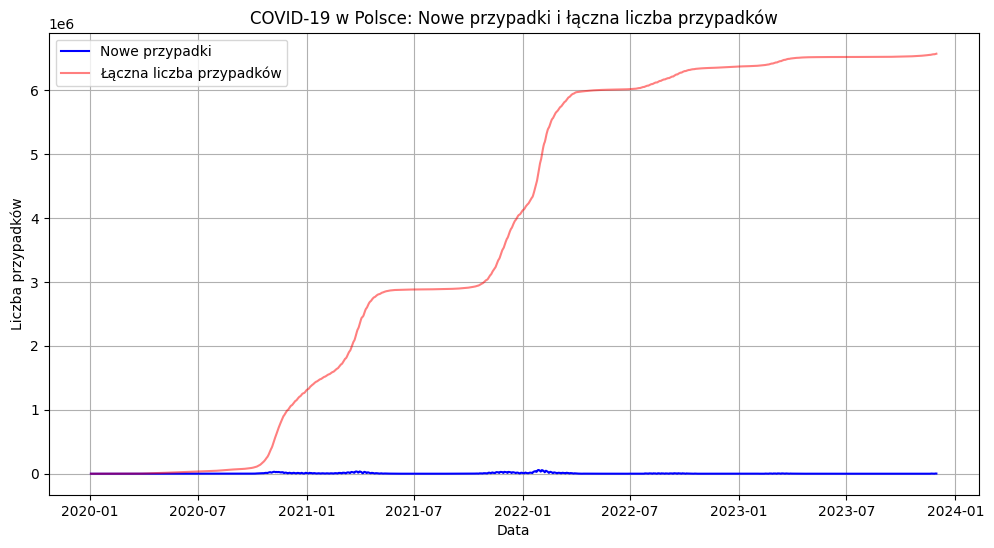

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['new_cases'], label='Nowe przypadki', color='blue')
plt.plot(df['total_cases'], label='Łączna liczba przypadków', color='red', alpha=0.5)
plt.title('COVID-19 w Polsce: Nowe przypadki i łączna liczba przypadków')
plt.xlabel('Data')
plt.ylabel('Liczba przypadków')
plt.legend()
plt.grid(True)
plt.show()


Na wykresie widzimy, że liczba nowych przypadków COVID-19 w Polsce wykazuje pewne wzorce, które mogą być związane z sezonowością, zmianami w polityce zdrowotnej, czy pojawieniem się nowych wariantów wirusa. Zauważalne są również wyraźne szczyty, które mogą odpowiadać falom pandemii.

Aby lepiej zrozumieć te wzorce i przygotować się do modelowania, przeprowadzimy dekompozycję szeregów czasowych, aby oddzielić trend, sezonowość i komponent losowy.

### Przedstawienie Tygodniowych danych VS Średnio miesięcznych

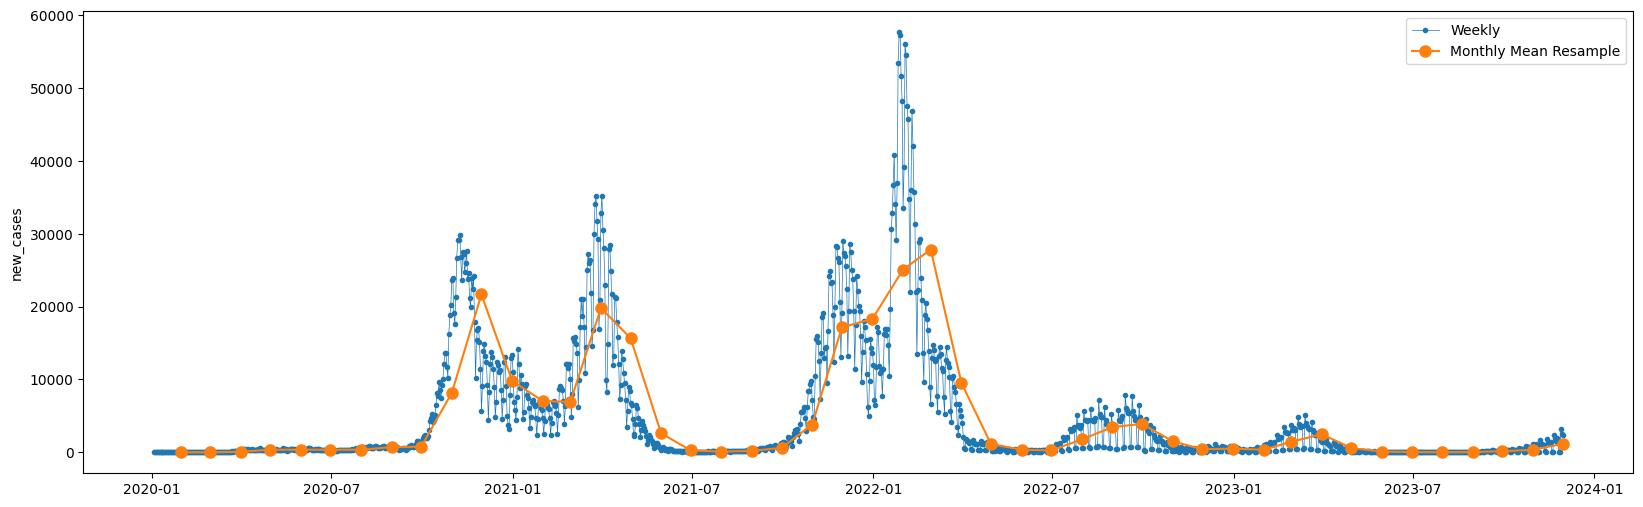

In [14]:
y = df[['new_cases']]
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('new_cases')
ax.legend();

1. Sezonowość i Trendy: Wykres wskazuje na istnienie sezonowości i trendów w danych. Można zauważyć pewne okresowe wzrosty i spadki, które mogą odpowiadać sezonowym wzrostom zachorowań, np. w okresach jesienno-zimowych.
<br>
<br>
2. Wahania Krótkoterminowe vs. Długoterminowe: Tygodniowe dane ukazują bardziej zmienną naturę rozprzestrzeniania się wirusa, co może być związane z różnymi czynnikami, takimi jak zmiany w polityce zdrowotnej, wprowadzanie lub znoszenie restrykcji, a także czynniki zewnętrzne. Średnia miesięczna pomaga wygładzić te wahania i lepiej zrozumieć ogólny kierunek zmian.
<br>
<br>
3. Wartości Ekstremalne: W danych tygodniowych można zauważyć kilka wyraźnych szczytów, co może wskazywać na fale pandemii lub nagłe wzrosty liczby przypadków.

### Dekompozycja szeregów czasowych (trend, sezonowość i komponent losowy)

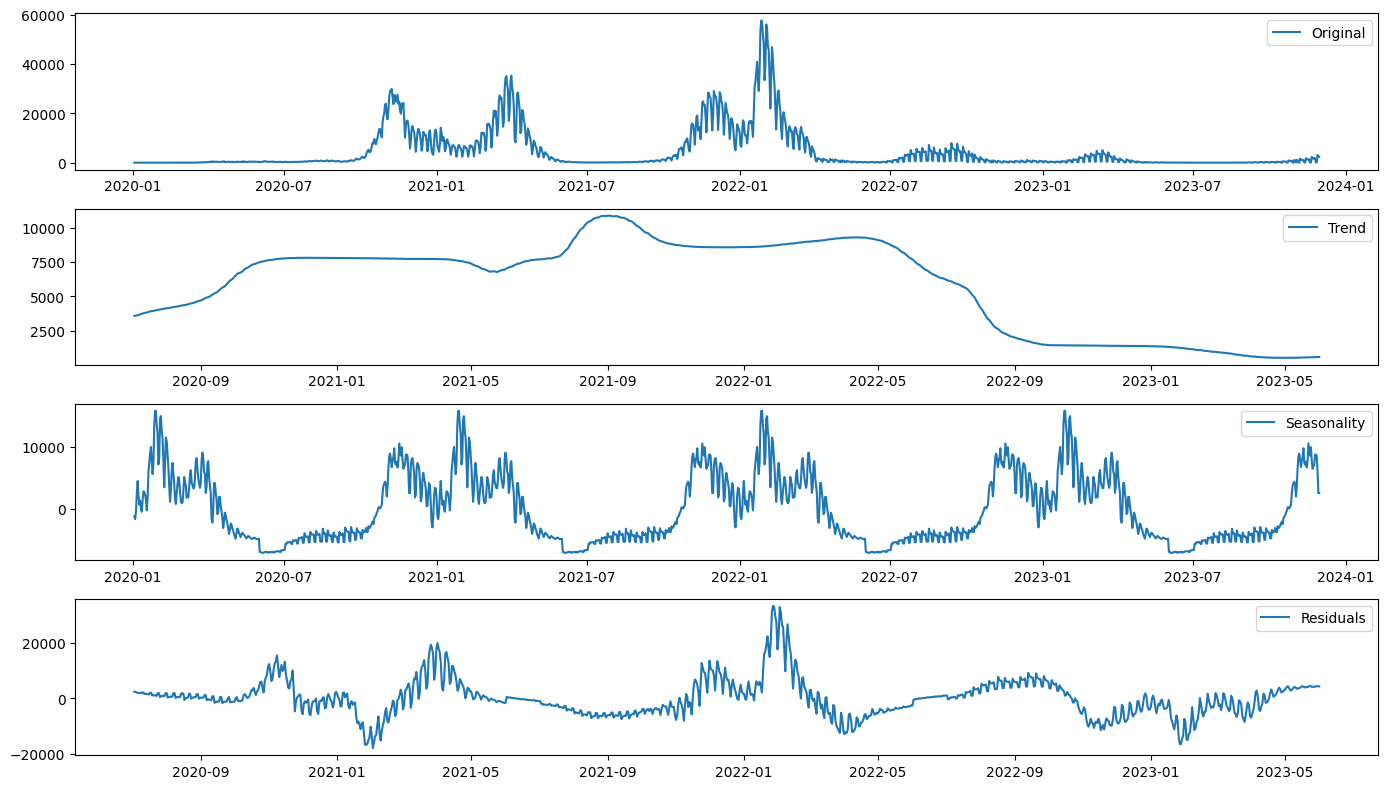

In [15]:
decomposition = seasonal_decompose(df['new_cases'], model='additive', period=365)

# Wyodrębnienie składników
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Wizualizacja dekompozycji
plt.figure(figsize=(14, 8))

plt.subplot(411)
plt.plot(df['new_cases'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
#plt.ylim(-20000, 40000)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
#plt.ylim(-20000, 40000)

plt.tight_layout()
plt.show()

1. Oryginalny Szereg Czasowy: Wykres pokazuje oryginalne dane dotyczące nowych przypadków COVID-19, z uwzględnieniem wszystkich fluktuacji.
<br>
<br>
2. Trend: Wskazuje na ogólny wzór lub kierunek w danych, ignorując krótkoterminowe wahania. Widać, jak zmieniała się ogólna liczba nowych przypadków COVID-19 w czasie.
<br>
<br>
3. Sezonowość: Wyraźnie pokazuje wzorce sezonowe, które powtarzają się w regularnych odstępach czasu. Można zauważyć, czy istnieją cykliczne wzrosty lub spadki liczby nowych przypadków.
<br>
<br>
4. Reszty (Residuals): Te dane reprezentują komponent losowy, który nie jest wyjaśniony przez trend ani sezonowość. Zawiera on wszelkie anomalie i nieregularności w danych.

### Sprawdzenie stacjonarności

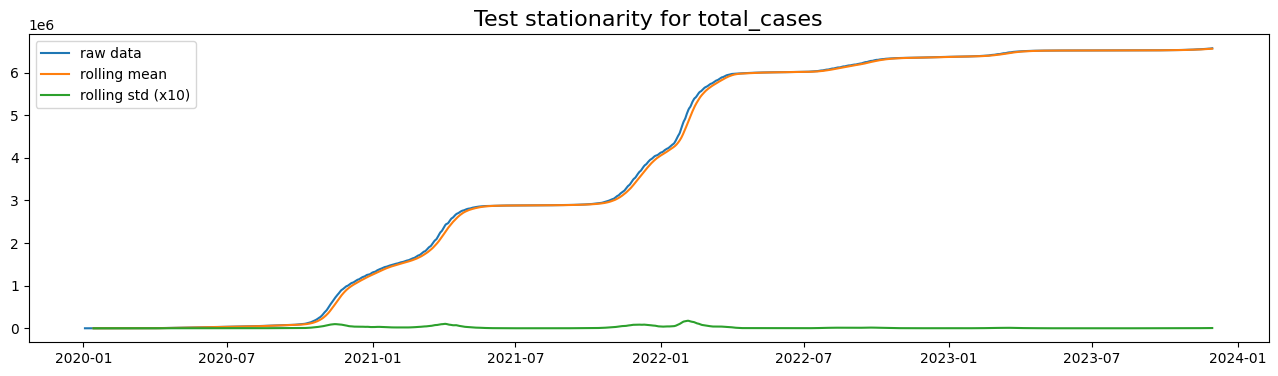

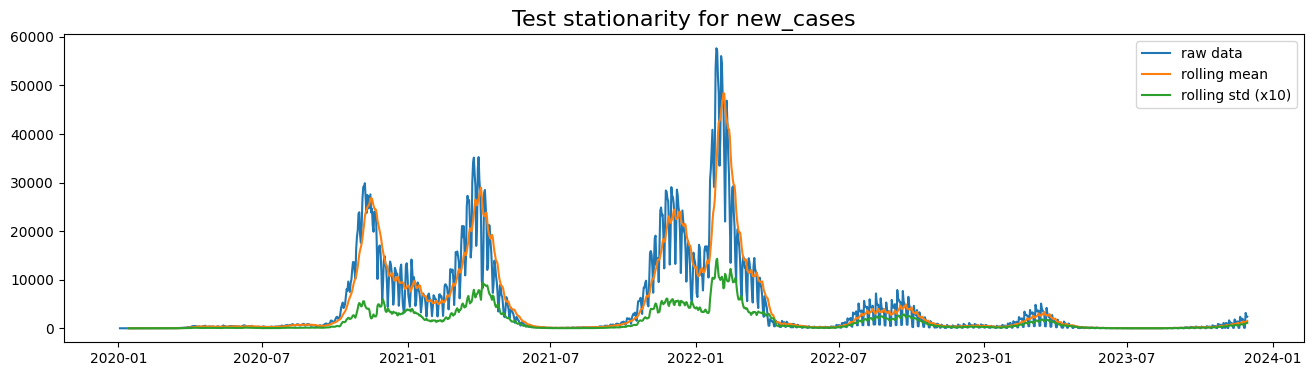

In [16]:
for col in df.columns:
    y = df[col]
    rolmean = pd.Series(y).rolling(window=12).mean() 
    rolstd = pd.Series(y).rolling(window=12).std()   
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y, label= 'raw data')
    ax.plot(rolmean, label='rolling mean')
    ax.plot(rolstd, label='rolling std (x10)')
    plt.title("Test stationarity for {}".format(col),fontdict=font)
    ax.legend()

1. Total Cases (Łączna liczba przypadków)
- Surowe Dane: Wykazują ciągły wzrost łącznej liczby przypadków COVID-19 w Polsce.
- Średnia Ruchoma: Potwierdza długoterminowy wzrostowy trend w danych. Średnia ruchoma stale rośnie, co wskazuje na ciągłe zwiększanie się łącznej liczby przypadków.
- Odchylenie Standardowe Ruchome: Również rośnie, sugerując wzrost zmienności danych w czasie. 
<br>
<br>
2. New Cases (Nowe przypadki)
- Surowe Dane: Pokazują zmienność w liczbie nowych przypadków w czasie, z widocznymi wzrostami i spadkami.
- Średnia Ruchoma: Fluktuacje w średniej ruchomej odzwierciedlają sezonowe wzorce oraz okresowe fale epidemii.
- Odchylenie Standardowe Ruchome: Waha się w czasie, co wskazuje na nieregularną zmienność w liczbie nowych przypadków.
<br>

#### Trendy i Stacjonarność: W obu kolumnach widać niestacjonarność danych, co oznacza, że zarówno średnia jak i wariancja zmieniają się w czasie. Jest to typowe dla danych epidemiologicznych, gdzie liczba przypadków rośnie w miarę rozprzestrzeniania się choroby.

### Sprawdzenie stacjonarności za pomocą testu statystycznego

In [17]:
def check_stationary(cols_check: List[str]) -> List[str]:
    non_stationary_columns_corrected = []

    for col in df.columns:
        y = df[col]
        print('Is the {} stationary ?'.format(col))
        test = adfuller(y.dropna(), autolag='AIC')
        print('Test statistic = {:.3f}'.format(test[0]))
        print('P-value = {:.3f}'.format(test[1]))
        print('Critical values :')
        for k, v in test[4].items():
            print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))
        print("-"*100)
        if test[1] > 0.05:
            non_stationary_columns_corrected.append(col)
        print(non_stationary_columns_corrected)
    return non_stationary_columns_corrected

In [18]:
non_stationary_cols = check_stationary(df.columns)

Is the total_cases stationary ?
Test statistic = -1.192
P-value = 0.677
Critical values :
	1%: -3.4350161653396736 - The data is not stationary with 99% confidence
	5%: -2.863600780613854 - The data is not stationary with 95% confidence
	10%: -2.567867151504452 - The data is not stationary with 90% confidence
----------------------------------------------------------------------------------------------------
['total_cases']
Is the new_cases stationary ?
Test statistic = -3.410
P-value = 0.011
Critical values :
	1%: -3.435019497302916 - The data is not stationary with 99% confidence
	5%: -2.863602251005175 - The data is  stationary with 95% confidence
	10%: -2.567867934524786 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
['total_cases']


1. Total Cases:
- Wysoka p-wartość (0.677) i wartość statystyki testowej (-1.192) większa od wartości krytycznych na wszystkich poziomach istotności wskazują, że szereg czasowy dla łącznej liczby przypadków nie jest stacjonarny. Oznacza to, że dane te posiadają trend i/lub zmieniającą się wariancję w czasie.
<br>
<br>
2. New Cases:
- Niska p-wartość (0.011) i wartość statystyki testowej (-3.410), która jest mniejsza od wartości krytycznych na poziomach istotności 5% i 10%, sugerują, że szereg czasowy dla nowych przypadków jest stacjonarny na tych poziomach. Oznacza to, że dane te mają stałą średnią i wariancję w czasie.

### Zastosowanie różnicowania pierwszego rzędu do szeregu czasowego 'total_cases', żeby zrobić dane stacjonarne

In [19]:
for col in non_stationary_cols:
    df[col] = df[col].diff().dropna()
    
non_stationary_cols = check_stationary(df.columns)
assert len(non_stationary_cols) == 0

Is the total_cases stationary ?
Test statistic = -3.409
P-value = 0.011
Critical values :
	1%: -3.4350228340280737 - The data is not stationary with 99% confidence
	5%: -2.86360372349629 - The data is  stationary with 95% confidence
	10%: -2.567868718663576 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
[]
Is the new_cases stationary ?
Test statistic = -3.410
P-value = 0.011
Critical values :
	1%: -3.435019497302916 - The data is not stationary with 99% confidence
	5%: -2.863602251005175 - The data is  stationary with 95% confidence
	10%: -2.567867934524786 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
[]


In [20]:
# Sprawdzenie braków 
df[df['new_cases'].isnull()]
df[df['total_cases'].isnull()]

,total_cases,new_cases
date,,
2020-01-03,NaN,0.0


In [21]:
# Uzupełnienie braków
df['total_cases'] = df['total_cases'].fillna(0)
df[df['total_cases'].isnull()]

,total_cases,new_cases
date,,


### Stworzenie nowej ramki danych na potrzeby modelu

In [22]:
df_proph = df[['new_cases']]
df_proph.reset_index(inplace=True)
df_proph.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
df_proph.head()

,ds,y
0,2020-01-03,0.0
1,2020-01-04,0.0
2,2020-01-05,0.0
3,2020-01-06,0.0
4,2020-01-07,0.0


In [23]:
# Definicja daty startu i podziału
start_date = '2020-07-01'

# Wyfiltrowanie danych od 07.2020
df_filtered = df_proph[df_proph['ds'] >= start_date]

### Określenie parametrów dla modelu przy wykorzystaniu cross walidacji

In [24]:
METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

folds_val, folds_test = NeuralProphet(**params).double_crossvalidation_split_df(
    df_proph, freq="D", k=5, valid_pct=0.25, test_pct=0.25
)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [ ]:
set_random_seed(123)

metrics_train1 = pd.DataFrame(columns=METRICS)
metrics_val = pd.DataFrame(columns=METRICS_VAL)
for df_train1, df_val in folds_val:
    m = NeuralProphet(**params)
    m.set_plotting_backend("plotly")
    train1 = m.fit(df=df_train1, freq="D")
    val = m.test(df=df_val)
    metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])
    metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

metrics_train2 = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS_VAL)
for df_train2, df_test in folds_test:
    m = NeuralProphet(**params)
    m.set_plotting_backend("plotly")
    train2 = m.fit(df=df_train2, freq="D")
    test = m.test(df=df_test)
    metrics_train2 = metrics_train2.append(train2[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 216


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.873% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normaliza

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.14373010396957397
         MAE_val              10694.423828125
        RMSE_val              13405.201171875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.884% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normaliza

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.1382097452878952
         MAE_val             12678.5322265625
        RMSE_val              14955.009765625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normaliza

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0006074499688111246
         MAE_val             712.5231323242188
        RMSE_val             972.337158203125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalizati

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.011324441991746426
         MAE_val             3546.142333984375
        RMSE_val                4124.328125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_val = metrics_val.append(val[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.907% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normaliza

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.10641546547412872
         MAE_val             10554.8076171875
        RMSE_val               12435.7734375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_train2 = metrics_train2.append(train2[METRICS].iloc[-1])

WARNING - (py.warnings._showwarnmsg) - /var/folders/y5/2z6ljk6d3nbgf1yjf30sgxc80000gn/T/ipykernel_24158/335142375.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_test = metrics_test.append(test[METRICS_VAL].iloc[-1])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0017902534455060959
         MAE_val            1017.4017333984375
        RMSE_val             1586.874267578125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

In [ ]:
metrics_train2.describe().loc[["mean", "std"]]

In [ ]:
metrics_val.describe().loc[["mean", "std"]]

In [ ]:
metrics_test.describe().loc[["mean", "std"]]

### Implementacja modelu i prognozowanie dla wybranych najlepszych parametrów

In [ ]:
set_random_seed(123)

m = NeuralProphet(**params)
m.set_plotting_backend("plotly")
metrics_train2 = m.fit(df=df_proph, freq="D")
future = m.make_future_dataframe(df_proph, periods=31, n_historic_predictions=True)
forecast = m.predict(future)
m.plot(forecast)

In [ ]:
forecast.tail(31)

### Wykresy trendu oraz sezonowości: rocznej oraz 

In [ ]:
m.plot_parameters(components=["trend", "seasonality"])

### Wykres liczby nowych przypadków i łącznej liczby przypadków

In [ ]:
december_2023_forecast = forecast[(forecast['ds'].dt.month == 12) & (forecast['ds'].dt.year == 2023)]
aggregated_result = december_2023_forecast['yhat1'].sum()
print(f"Prognozowana liczba zakażeń w miesiącu grudzień jest równa: {round(aggregated_result)}")